# Evolutionary model for the CRD with Timing uncertainty

This notebook produces Figure 4 of the manuscript
"Timing uncertainty in collective risk dilemmas encourages group reciprocation and polarization"

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
old_err_state = np.seterr(divide='raise')
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from egttools.analytical.sed_analytical import StochDynamics
from estimate_payoff import EstimatePayoffsCRD, actions
flatten = lambda l: [item for sublist in l for item in sublist]

First we define the parameters

In [3]:
Z = 50
N = 6.0       # group size
r = 0.9       # risk
beta = .004    # We choose this beta after exploring its effects, and finding that if offers the best fit
mu = 0.0
drift = 1/float(Z)
iterations = 1000
risk = 0.9
m0s = [10, 8, 6]
ws = [1., 1./3., 1./5.]
# Threshold used by the conditional strategies to decide on an action
agent_threshold = actions[1] * (N - 1) # fair donation
# Expected fraction of successful groups (or group achievement)
# For compensators and fair players, achieving the target depends on the probability
# that they will have enough time to make the contributions
group_achievement = np.array([
    [0., 1., 1., 0., 1.],
    [0., (1-ws[1])**(10-m0s[1]), 1., (1-ws[1])**(11-m0s[1]), 1.],
    [0., (1-ws[2])**(10-m0s[2]), 1., (1-ws[2])**(11-m0s[2]), 1.]
])
target = actions[1] * N * m0s[0]
endowment = 2 * actions[1] * m0s[0]

## No uncertainty

Estimate payoffs and calculate stationary distribution

In [4]:
# Only needs one iteration since the number of rounds is deterministic
payoffs = EstimatePayoffsCRD.estimate_payoffs(N, target, agent_threshold, r, m0s[0], ws[0],
                                              endowment, iterations=1, uncertainty=False,
                                              save_name='data/payoffs_crd_nu')
sd = StochDynamics(EstimatePayoffsCRD.ns, payoffs, Z, N, mu=mu)
p_stationary_nu = sd.calculate_stationary_distribution(beta)

## Low uncertainty


In [5]:
payoffs = EstimatePayoffsCRD.estimate_payoffs(N, target, agent_threshold, r, m0s[1], ws[1],
                                              endowment, iterations=10000, uncertainty=True,
                                              save_name='data/payoffs_crd_lu')
sd = StochDynamics(EstimatePayoffsCRD.ns, payoffs, Z, N, mu=mu)
p_stationary_lu = sd.calculate_stationary_distribution(beta)

## High uncertainty

In [6]:
payoffs = EstimatePayoffsCRD.estimate_payoffs(N, target, agent_threshold, r, m0s[2], ws[2],
                                              endowment, iterations=10000, uncertainty=True,
                                              save_name='data/payoffs_crd_hu')
sd = StochDynamics(EstimatePayoffsCRD.ns, payoffs, Z, N, mu=mu)
p_stationary_hu = sd.calculate_stationary_distribution(beta)


Now we input the stationary distribution results into a matrix
and calculate the group achievement

In [7]:
stationary = np.asarray([p_stationary_nu, p_stationary_lu, p_stationary_hu])
etas = np.asarray([np.dot(stationary[i, :], group_achievement[i, :]) for i in range(3)])
# proportion of reciprocal behaviours in successful groups
proportion_reciprocals = stationary[:, -1] / etas

# Calculate polarisation
c_big_nu = np.array([0., 0., 0., 0., 1.])
c_equal_nu = np.array([0., 1., 1., 0., 0.])
c_small_nu = np.array([1., 0., 0., 1., 0.])
cs_nu = np.asarray([c_big_nu, c_equal_nu, c_small_nu])

c_big_lu = np.array([0., 0., 0., (1-ws[1])**(11 - m0s[1]), 1.])
c_equal_lu = np.array([0., (1-ws[1])**(10 - m0s[1]), 1., 0., 0.])
c_small_lu = np.array([1., 1 - (1-ws[1])**(10 - m0s[1]), 0., 1 - (1-ws[1])**(11 - m0s[1]), 0.])
cs_lu = np.asarray([c_big_lu, c_equal_lu, c_small_lu])

c_big_hu = np.array([0., 0., 0., (1-ws[2])**(11 - m0s[2]), 1.])
c_equal_hu = np.array([0., (1-ws[2])**(10 - m0s[2]), 1., 0., 0.])
c_small_hu = np.array([1., 1 - (1-ws[2])**(10 - m0s[2]), 0., 1 - (1-ws[2])**(11 - m0s[2]), 0.])
cs_hu = np.asarray([c_big_hu, c_equal_hu, c_small_hu])

cs = np.asarray([cs_nu, cs_lu, cs_hu])
polarisation = np.asarray([[np.dot(stationary[i, :], cs[i, j, :]) for j in range(3)] for i in range(3)])

## Plot results

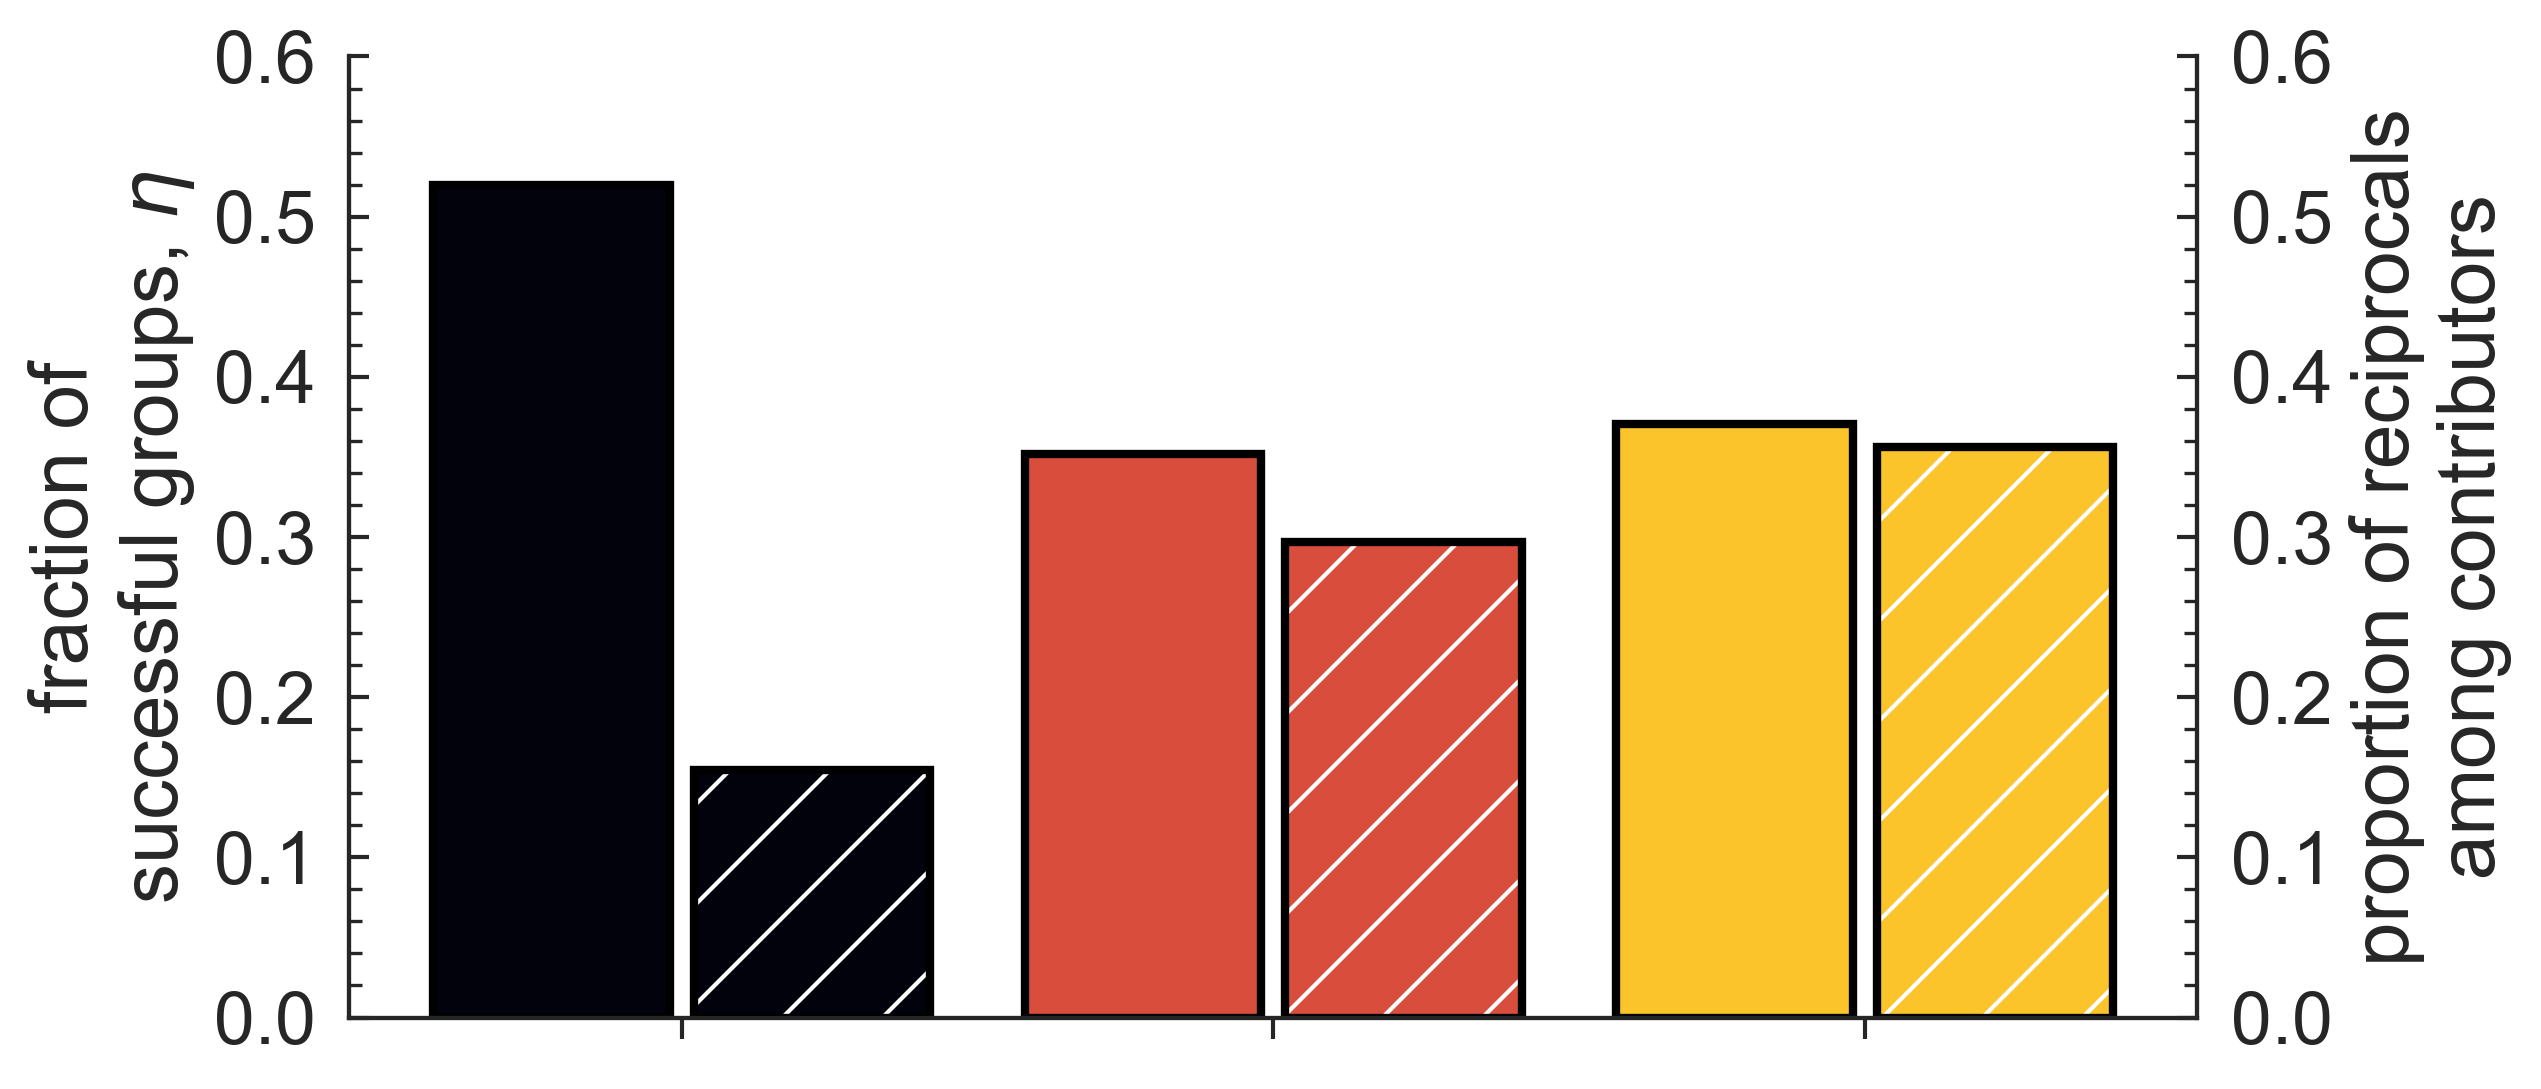

In [8]:
# Figure 4a

sns.set_style("ticks")
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.0,
                                              "lines.markersize": 8,
                                              "lines.markeredgewidth": 10,
                                             })

space = 0.22
colors = np.asarray(sns.color_palette("inferno", 50))[[0, 29, 43]]

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

ax.bar(x=[0 - space, 1 - space, 2 - space],
       height=etas, width=0.4,
        color=colors, edgecolor='k', linewidth=2.
        )

t_type = ["no uncertainty", "uncertainty", "uncertainty"]
ax.set_position([0.1,0.1,0.6,0.9])
ax.set_ylabel("fraction of\nsuccessful groups, $\\eta$")
ax.set_ylim(0, 0.6)
ax.tick_params(axis="y", direction="in", pad=8)
ax.tick_params(axis="y", which="minor", direction="in")
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(axis="x", length=5, pad=8)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(x=[0 + space, 1 + space, 2 + space],
       height=proportion_reciprocals, width=0.4,
        color=colors, edgecolor='white', hatch='/', lw=1., zorder=0
        )
ax2.bar(x=[0 + space, 1 + space, 2 + space],
       height=proportion_reciprocals, width=0.4,
        color='none', edgecolor='k', lw=2., zorder=1
        )
ax2.set_position([0.1,0.1,0.6,0.9])
ax2.set_ylabel("proportion of reciprocals\namong contributors")
# plt.yticks(range(0, 1, 21))
ax2.set_ylim(0, 0.6)
ax2.tick_params(axis="y", direction="in", pad=8)
ax2.tick_params(axis="y", which="minor", direction="in")
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
fig.tight_layout()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["", "", ""])

sns.despine(offset=0, bottom=False, right=False)

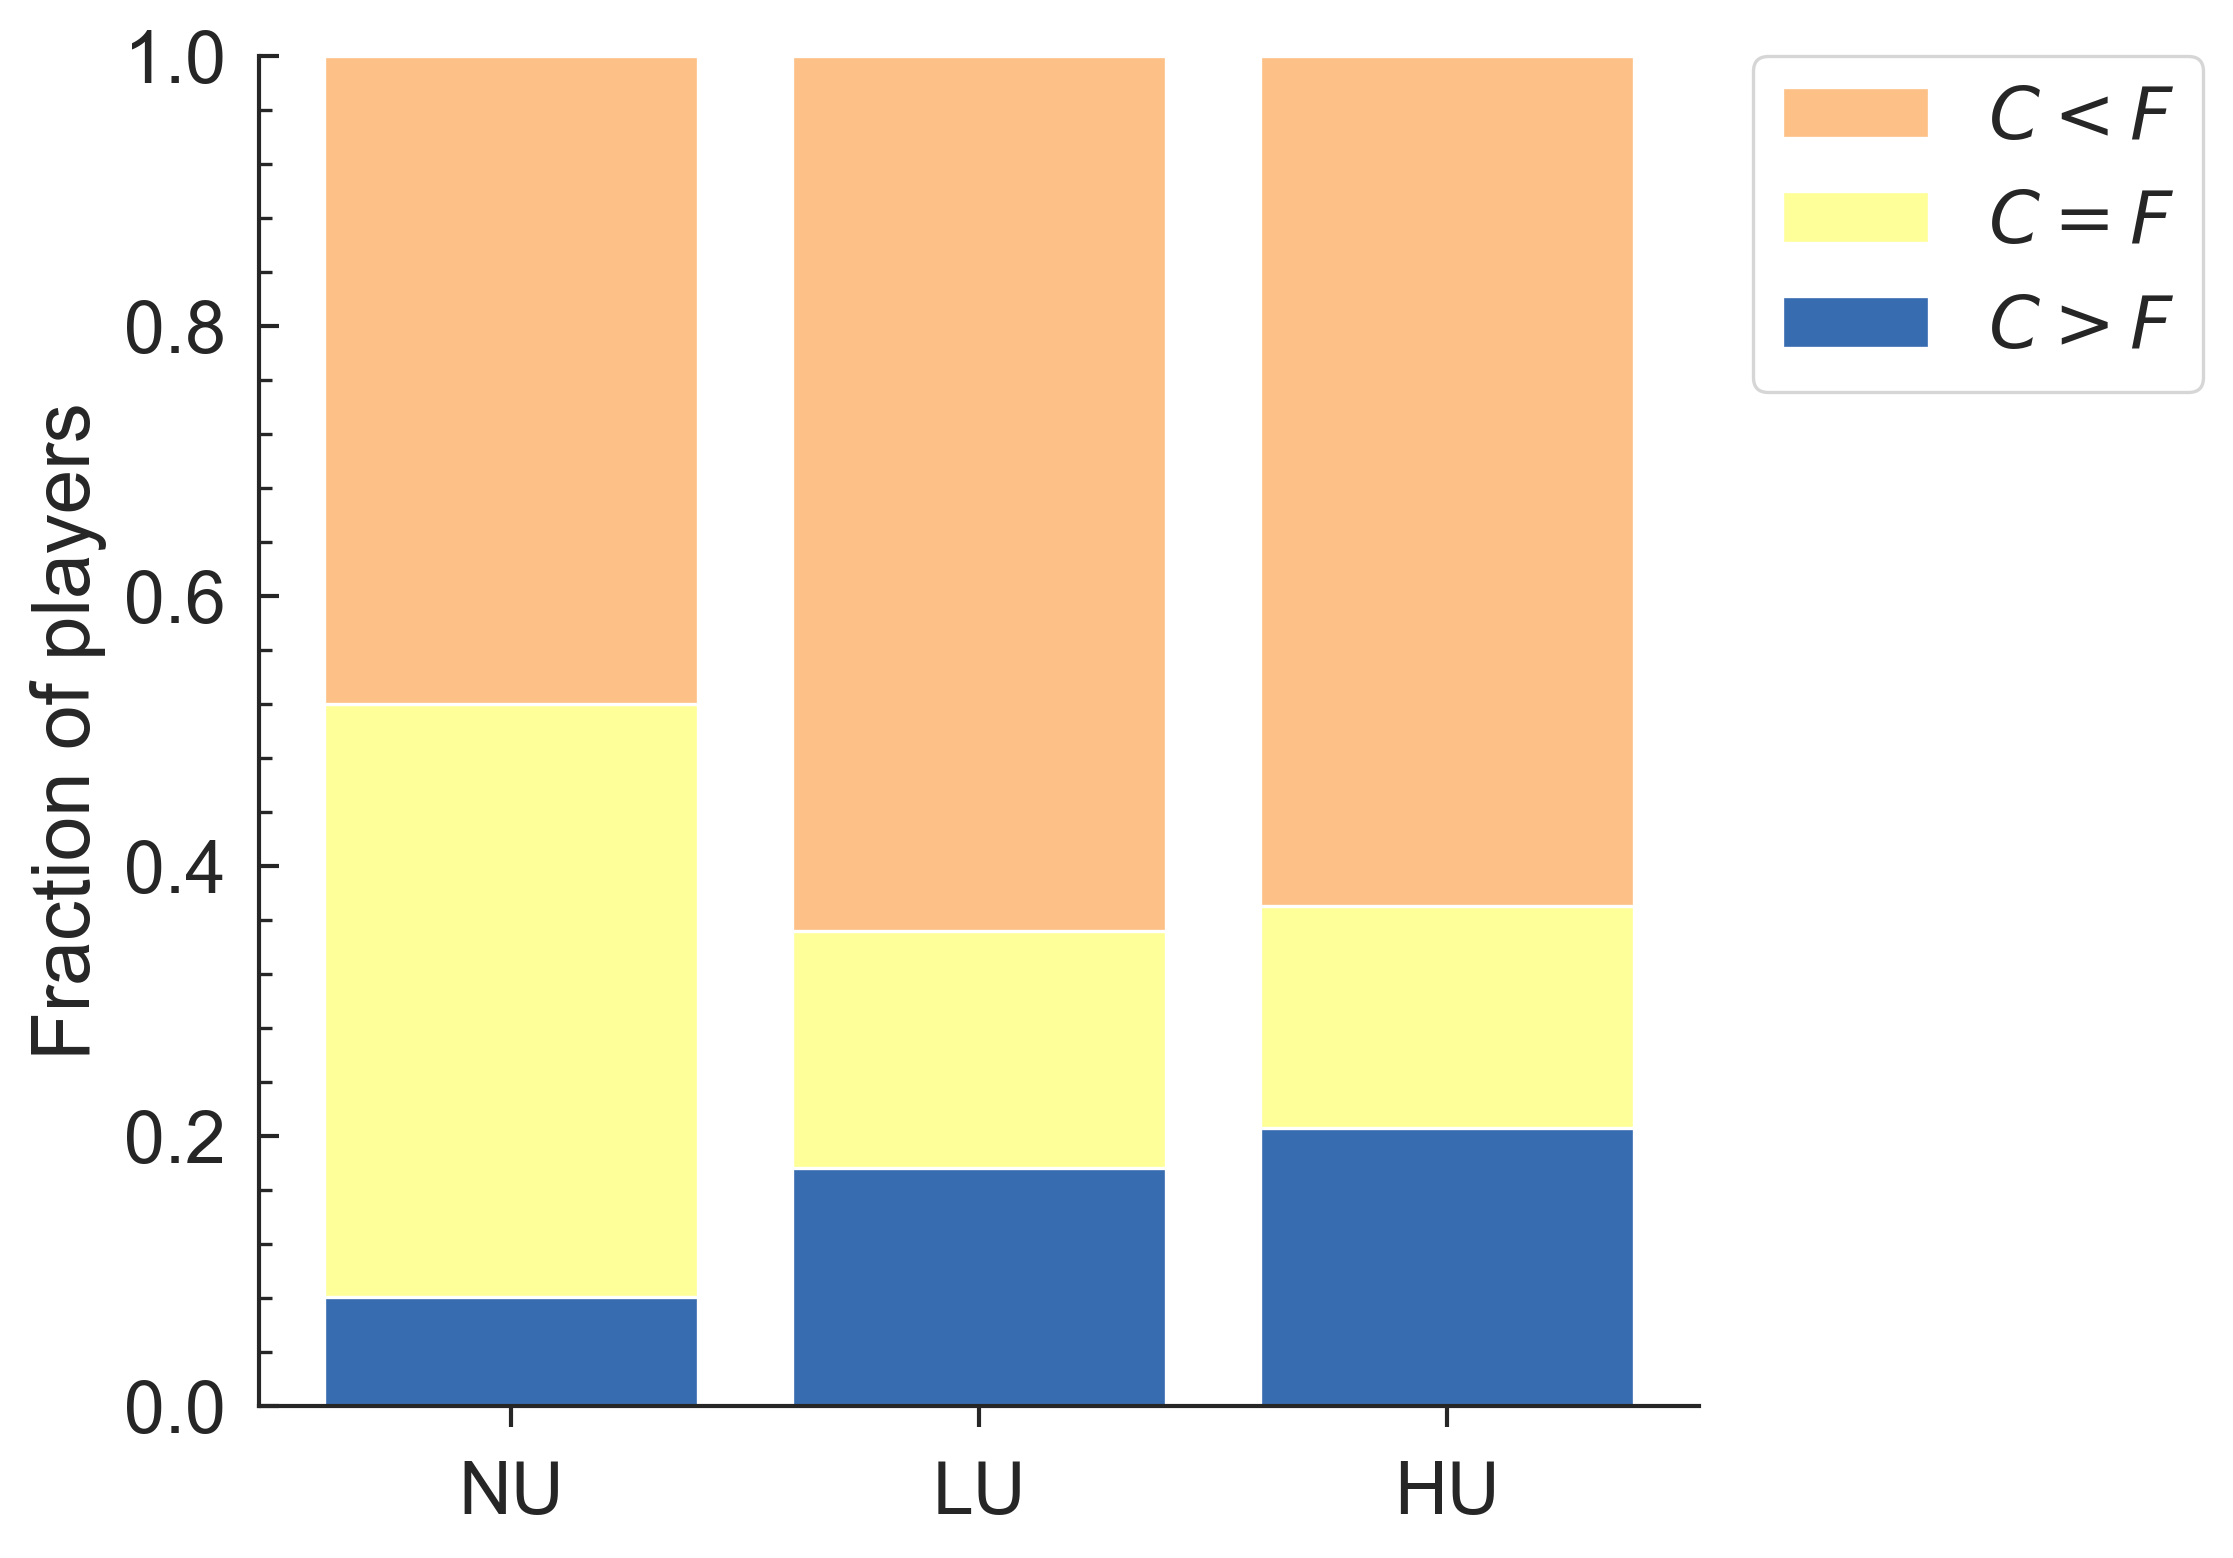

In [9]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", font_scale=2., rc={"lines.linewidth": 5.0,
                                              "lines.markersize": 8,
                                              "lines.markeredgewidth": 10,
                                             })

s1 = polarisation[:, 0]
s2 = s1 + polarisation[:, 1]
s3 = s2 + polarisation[:, 2]

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
plt.bar(x=[1, 2, 3], height=s3, color="#fdc086", label="$C<F$")
plt.bar(x=[1, 2, 3], height=s2, color="#ffff99", label="$C=F$")
plt.bar(x=[1, 2, 3], height=s1, color="#386cb0", label="$C>F$")
ax.set_position([0.1,0.1,0.6,0.9])
L = plt.legend(bbox_to_anchor=(1.35, 1.), loc='upper right', borderaxespad=0.)
ax.set_ylabel("Fraction of players")
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["NU", "LU", "HU"])
# plt.yticks(range(0, 1, 21))
ax.set_ylim(0, 1)
ax.tick_params(axis="y", direction="in", pad=8)
ax.tick_params(axis="y", which="minor", direction="in")
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(axis="x", length=5, pad=8)

sns.despine(offset=0, bottom=False)